Study summary

The Department of Cardiology is interested and exploring the possibility of identifying pathologic cardiac hypertrophy from physiological cardiac hypertrophy. They first designed a pilot study that enrolled 50 patients, for which they collected basic patient and cardiac function information to evaluate their hypothesis and the feasibility of the project. After such small pilot, they collected additional data from 200 subjects with hypertrophic cardiomyopathy.

Goals:

    - [x] Use logistic regression to evaluate the feasibility of identifying pathologic cardiac hypertrophy in the pilot dataset with 50 subjects.
    - [x] Use cross-validation to evaluate performance using different test group sizes (1, 10, 20, 30, 40) in terms of accuracy and area under the ROC curve.
    - [x] Visualize the ROC curves for different test group sizes and discuss the observed differences.
    - [x] Repeat the study with the larger dataset collected after the pilot. Evaluate and discuss the differences compared to the initial study.
    - Train a final model ready for deployment. What is the performance in the training dataset? What is the relationship between every variable and the predicted outcome?


The pilot study (50 samples) will have high variability in the cross validation performance (because the CVs will have much lower training samples)

Compare various CV results (with different k folds) using AUROC plots 

Plot the roc curve for different kfold sizes
    - Expect that the pilot study performance for different k folds will be much more variable

Address class imbalance (use stratified k fold cross validation)
If you use regularization, discuss why 

Scale the training data only



In [176]:
import numpy as np
import pandas as pd
import scipy
import shelve
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import category_encoders as ce
import seaborn as sns
from scipy.stats import normaltest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.optimize import minimize
from scipy.stats import shapiro
from scipy.special import expit

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [177]:
?StratifiedKFold

Init signature: StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)
Docstring:     
Stratified K-Folds cross-validator.

Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns
stratified folds. The folds are made by preserving the percentage of
samples for each class.

Read more in the :ref:`User Guide <stratified_k_fold>`.

Parameters
----------
n_splits : int, default=5
    Number of folds. Must be at least 2.

    .. versionchanged:: 0.22
        ``n_splits`` default value changed from 3 to 5.

shuffle : bool, default=False
    Whether to shuffle each class's samples before splitting into batches.
    Note that the samples within each split will not be shuffled.

random_state : int, RandomState instance or None, default=None
    When `shuffle` is True, `random_state` affects the ordering of the
    indices, which controls the randomness of each fold for each class.
    Otherwise, leave `random_sta

In [178]:
df_50 = pd.read_excel("CardiacHypertrophyData_50Samples.xlsx")
df_50.head()

,Age,Sex,Racial group,Ejection fraction,Heart rate (bpm),Systolic blood pressure,Pathologic?
0,59.053851,Male,Asian,0.625929,71.025200,98.960236,0
1,56.291312,Male,White,0.632001,51.666039,112.938934,0
2,66.216488,Male,White,0.601147,105.635574,98.363388,1
3,45.684119,Female,Black or African American,0.546039,96.767563,104.544754,0
4,69.492794,Female,White,0.677071,86.660133,129.907806,1


In [200]:

def onehot_encode_categorical(df, column_name, dropna = False):
    # encode sex
    if dropna:
        df = df.dropna()
    ohe = OneHotEncoder(sparse_output=False).fit(df[[column_name]])
    encoder_df = pd.DataFrame(ohe.transform(df[[column_name]]))
    print(f'before = {encoder_df.columns}')
    encoder_df.columns = [f'{column_name}_{col}' for col in encoder_df.columns]
    print(f'after = {encoder_df.columns}')
    df = df.join(encoder_df)
    df = df.drop(columns=[column_name])
    return(df, ohe)

df_50_encoded, _ = onehot_encode_categorical(df_50, "Sex")
df_50_encoded, ohe = onehot_encode_categorical(df_50_encoded, "Racial group")
df_50_encoded.head()


before = RangeIndex(start=0, stop=2, step=1)
after = Index(['Sex_0', 'Sex_1'], dtype='object')
before = RangeIndex(start=0, stop=6, step=1)
after = Index(['Racial group_0', 'Racial group_1', 'Racial group_2', 'Racial group_3',
       'Racial group_4', 'Racial group_5'],
      dtype='object')


,Age,Ejection fraction,Heart rate (bpm),Systolic blood pressure,Pathologic?,Sex_0,Sex_1,Racial group_0,Racial group_1,Racial group_2,Racial group_3,Racial group_4,Racial group_5
0,59.053851,0.625929,71.025200,98.960236,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,56.291312,0.632001,51.666039,112.938934,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,66.216488,0.601147,105.635574,98.363388,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,45.684119,0.546039,96.767563,104.544754,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,69.492794,0.677071,86.660133,129.907806,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [180]:
def standardize_df(df, *cols):
    df_num = df.loc[:, [*cols]].copy()
    df.loc[:, [*cols]] = (df_num-df_num.mean())/df_num.std()
    return df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


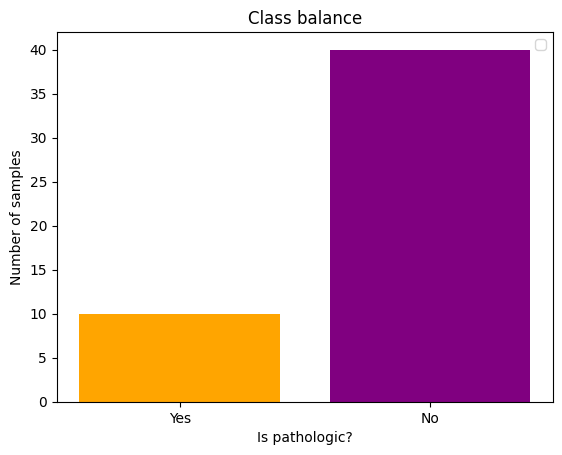

10

In [181]:
def viz_class_imbalance(df, label_col):
    ser = df.loc[:, label_col]
    pos_indices = ser[ser.values == 1].index
    neg_indices = ser[ser.values == 0].index
    n_pos = ser.iloc[pos_indices].count()
    n_neg = ser.iloc[neg_indices].count()
    plt.bar(["Yes", "No"], [n_pos, n_neg], color = ['orange', 'purple'])

    plt.xlabel("Is pathologic?")
    plt.ylabel("Number of samples")
    plt.title("Class balance")
    plt.legend()
    plt.show()
    return(n_pos)

viz_class_imbalance(df_50_encoded, "Pathologic?")


In [182]:
# mkae sure to use predict_proba() for predicted probabilites
# one ROC curve for each partition size
def cv_kfold_lr(df, k_folds = [25,10,5,2], random_state = 1, class_weight = None):
    y = df.loc[:, "Pathologic?"]
    X = df.drop(columns = ["Pathologic?"])

    performance_dict = {}

    for k in k_folds:
        cv = StratifiedKFold(n_splits=k, random_state=random_state,  shuffle=True)
        performance_dict[f'{k}_folds'] =  {"truth": [], "p_0": [], "p_1": [], "f1": [], "acc": []}
        performance_dict[f'{k}_folds']["k"] = k
        performance_dict[f'{k}_folds']['random_state'] = random_state
        for fold, (train, test) in enumerate(cv.split(X, y)):
            # subset based on fold indices
        
            X_train = X.iloc[train, :]
            X_test = X.iloc[test, :]
            numerical_cols = ["Age", "Ejection fraction", "Heart rate (bpm)", "Systolic blood pressure"]
            X_train = standardize_df(X_train, *numerical_cols)
            X_test = standardize_df(X_test, *numerical_cols)
            y_train = y.iloc[train]
            y_test = y.iloc[test]
            # standardize numericals separately for train and test

            clf = LogisticRegression(random_state=0, class_weight=class_weight)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_pred_prob = clf.predict_proba(X_test)
            pred_neg = y_pred_prob[:, 0].tolist()
            pred_pos = y_pred_prob[:, 1].tolist()
            acc = clf.score(X_test, y_test.tolist())
            f1 = f1_score(y_test.tolist(), y_pred, pos_label=1, zero_division=np.nan)
            performance_dict[f'{k}_folds']["truth"] += y_test.tolist()
            performance_dict[f'{k}_folds']["p_0"] += pred_neg
            performance_dict[f'{k}_folds']["p_1"] += pred_pos
            performance_dict[f'{k}_folds']["f1"] += [f1]
            performance_dict[f'{k}_folds']["acc"] += [acc]
        
        performance_dict[f'{k}_folds']["avg_acc"] = round(sum(performance_dict[f'{k}_folds']["acc"]) / len((performance_dict[f'{k}_folds']["acc"])),3)
        performance_dict[f'{k}_folds']["avg_f1"] = round(sum(performance_dict[f'{k}_folds']["f1"]) / len((performance_dict[f'{k}_folds']["f1"])),3)
        performance_dict[f'{k}_folds']["auroc"] = round(roc_auc_score(performance_dict[f'{k}_folds']["truth"], performance_dict[f'{k}_folds']["p_1"]), 3)
    return(performance_dict)
list_50n_res = [cv_kfold_lr(df_50_encoded, random_state=i)for i in range(4)]

/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=25.
  warnings.warn(


/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=25.
  warnings.warn(
/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=25.
  warnings.warn(
/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=25.
  warnings.warn(


In [183]:
#print(list(zip(dict_50n_res["2_folds"]["p_1"], dict_50n_res["2_folds"]["truth"])))
#print(list(zip(dict_50n_res["25_folds"]["p_1"], dict_50n_res["25_folds"]["truth"])))

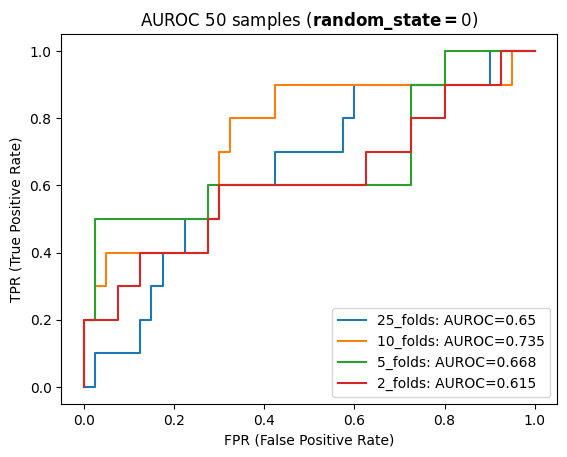

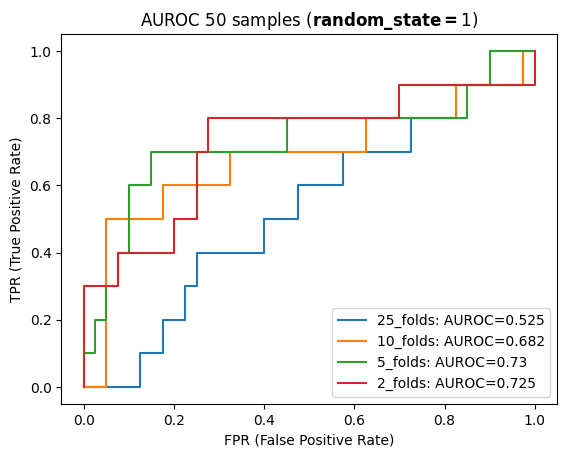

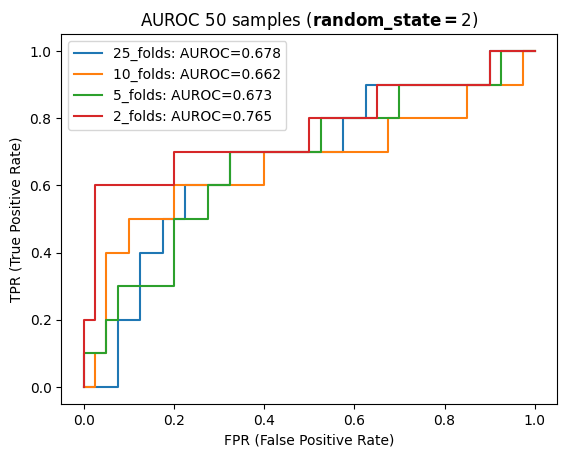

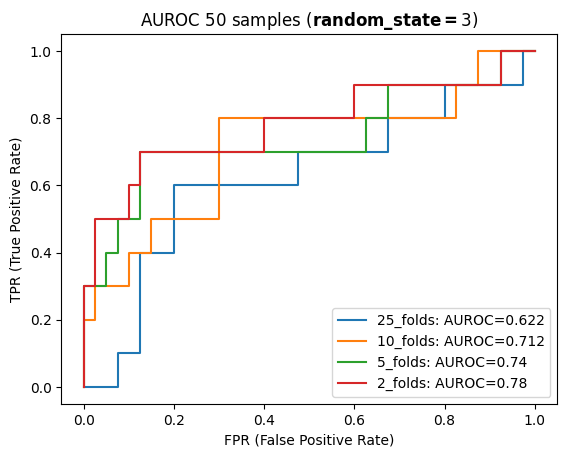

In [184]:
def plot_performance(performance_dict, title_str = r'Auroc ### samples ($\bf{random\_state=}$'):
    for k_fold in performance_dict.keys():
        truth = performance_dict[k_fold]["truth"]
        p_1 = performance_dict[k_fold]["p_1"]
        f1 = performance_dict[k_fold]["f1"]
        acc = performance_dict[k_fold]["acc"]
        avg_acc = performance_dict[k_fold]["avg_acc"]
        avg_f1 = round(performance_dict[k_fold]["avg_f1"], 3)
        fpr, tpr, thres = sklearn.metrics.roc_curve(truth, p_1, pos_label=1)
        auroc = performance_dict[k_fold]["auroc"]
        random_state = performance_dict[k_fold]["random_state"]
        plt.plot(fpr, tpr, label = f'{k_fold}: AUROC={auroc}') #avg_acc={avg_acc}; avg_f1={avg_f1}')
    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("TPR (True Positive Rate)")
    plt.title(title_str + f'{random_state})')
    plt.legend()
    plt.show()
    return(plt)
for d in list_50n_res:
    plot_performance(d, title_str = r'AUROC 50 samples $(\bf{random\_state=}$')

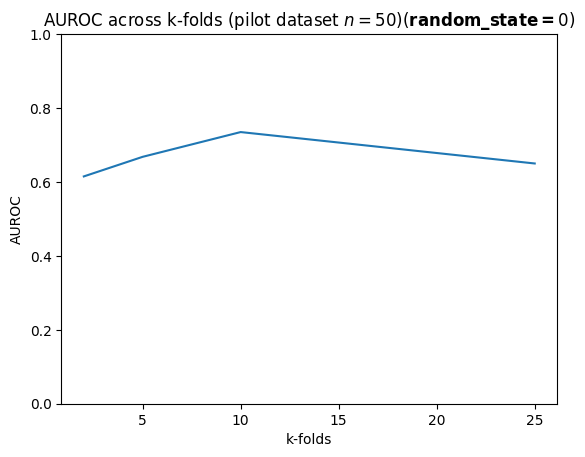

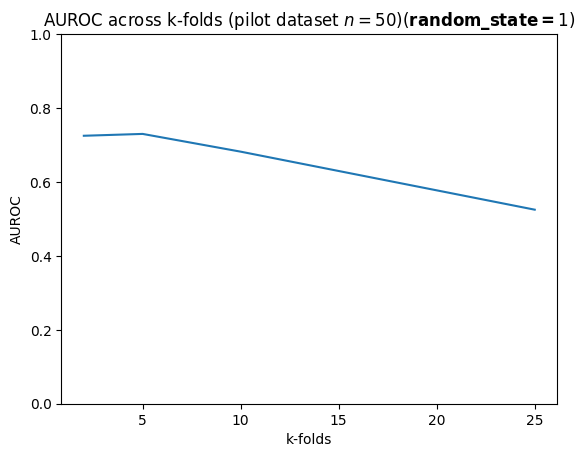

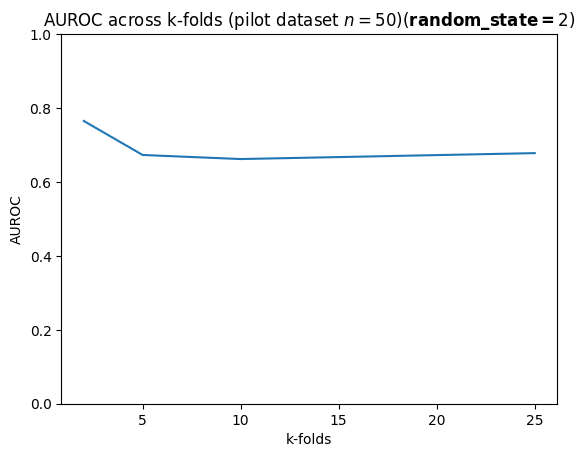

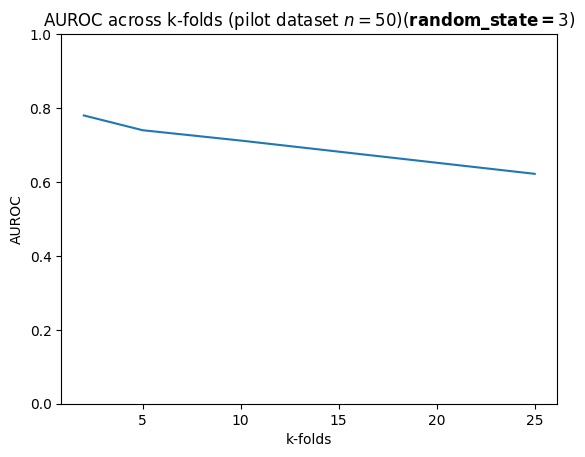

In [185]:
def k_v_auroc(performance_dict, title = "AUROC across k-folds"):

    aurocs = []
    k = []
    for k_fold in performance_dict.keys():
        aurocs.append(performance_dict[k_fold]["auroc"])
        k.append(performance_dict[k_fold]["k"])
    random_state = performance_dict[k_fold]["random_state"]
    
    plt.plot(k, aurocs)
    plt.xlabel("k-folds")
    plt.ylabel("AUROC")
    plt.ylim([0,1])
    plt.title(title + r'($\bf{random\_state=}$' + f'{random_state})')
    plt.show()
    return(plt)
for d in list_50n_res:
    k_v_auroc(d, title = "AUROC across k-folds (pilot dataset $n=50$)")



In [186]:
df_200 = pd.read_excel("CardiacHypertrophyData_200Samples.xlsx")
df_200.loc[:, "Racial group"].unique()

array(['White', 'Hispanic or Latino', 'Black or African American',
       'Asian', 'American Indian or Alaska Native',
       'Native Hawaiian or other Pacific Islander'], dtype=object)

In [187]:

df_200_encoded, _ = onehot_encode_categorical(df_200, "Sex")
df_200_encoded, ohe_race = onehot_encode_categorical(df_200_encoded, "Racial group")
print(ohe_race.categories_)
df_200_encoded.head()


before = RangeIndex(start=0, stop=2, step=1)
after = Index(['Sex_0', 'Sex_1'], dtype='object')
before = RangeIndex(start=0, stop=6, step=1)
after = Index(['Racial group_0', 'Racial group_1', 'Racial group_2', 'Racial group_3',
       'Racial group_4', 'Racial group_5'],
      dtype='object')
[array(['American Indian or Alaska Native', 'Asian',
       'Black or African American', 'Hispanic or Latino',
       'Native Hawaiian or other Pacific Islander', 'White'], dtype=object)]


,Age,Ejection fraction,Heart rate (bpm),Systolic blood pressure,Pathologic?,Sex_0,Sex_1,Racial group_0,Racial group_1,Racial group_2,Racial group_3,Racial group_4,Racial group_5
0,58.706430,0.581767,109.255325,120.983421,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,59.108509,0.706900,104.015976,111.671471,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,48.160970,0.644444,101.856407,95.749603,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,57.649055,0.572398,69.098885,103.728004,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,58.849777,0.616101,72.875412,104.763771,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


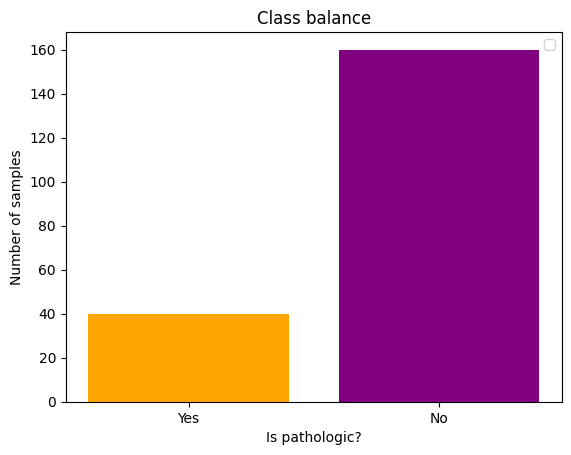

40

In [188]:
viz_class_imbalance(df_200_encoded, "Pathologic?")


In [189]:
# train and test 200 sample data set
list_200n_res = [cv_kfold_lr(df_200_encoded, k_folds=[2, 5, 10, 15, 20, 25, 50, 100], random_state=i) for i in range(5)]
# train and test 200n using weights for the classes
list_200n_res_weighted = [cv_kfold_lr(df_200_encoded, k_folds=[2, 5, 10, 15, 20, 25, 50, 100], random_state=i, class_weight="balanced") for i in range(5)]

/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 40 members, which is less than n_splits=50.
  warnings.warn(
/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 40 members, which is less than n_splits=100.
  warnings.warn(
/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 40 members, which is less than n_splits=50.
  warnings.warn(
/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 40 members, which is less than n_splits=100.
  warnings.warn(
/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

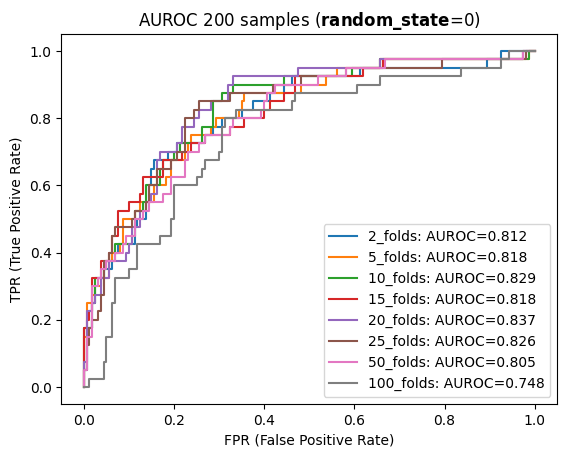

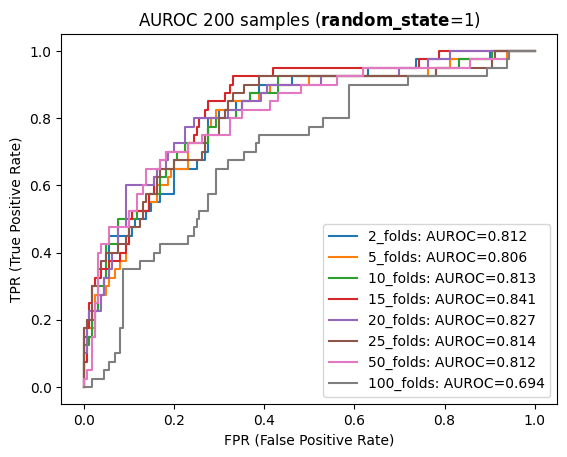

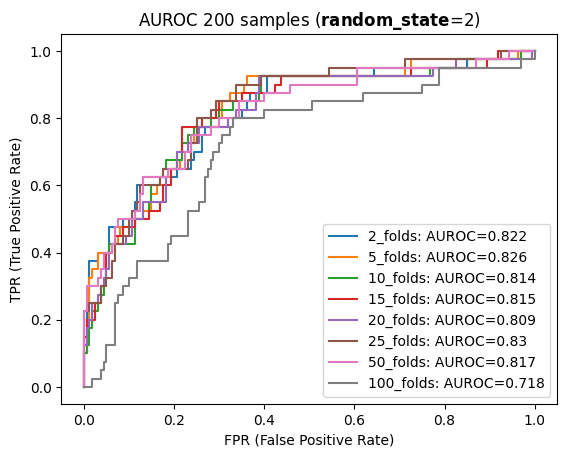

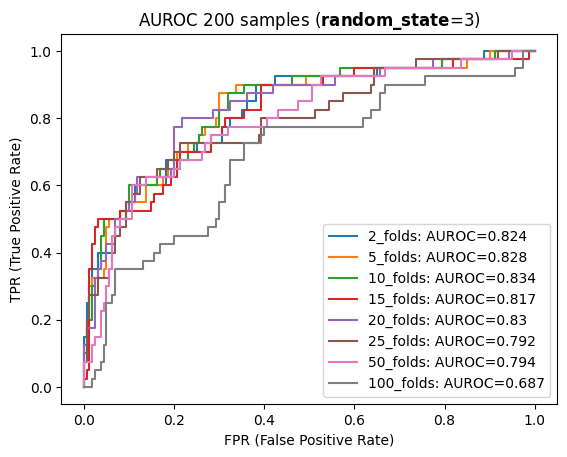

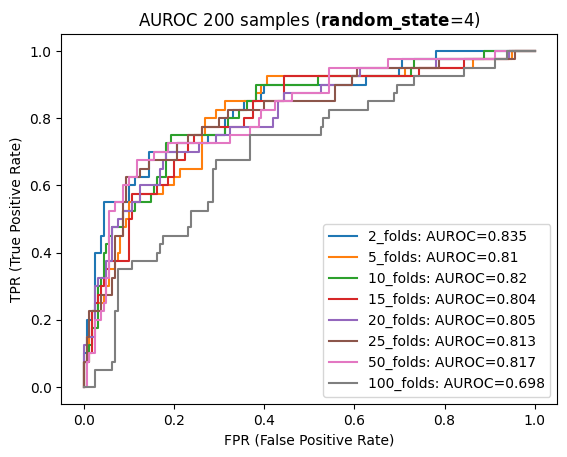

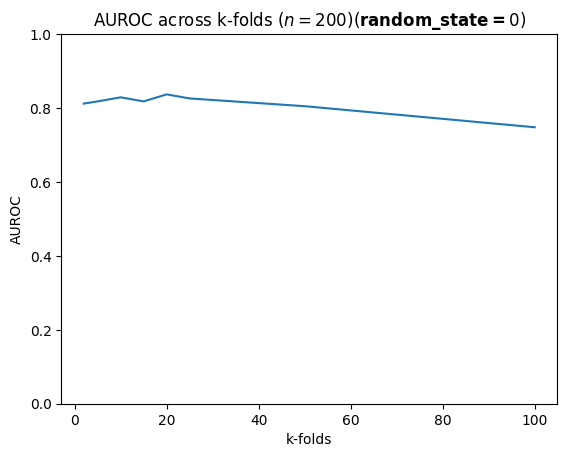

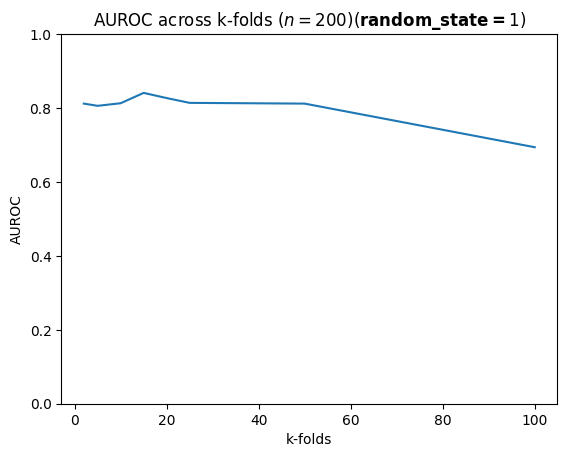

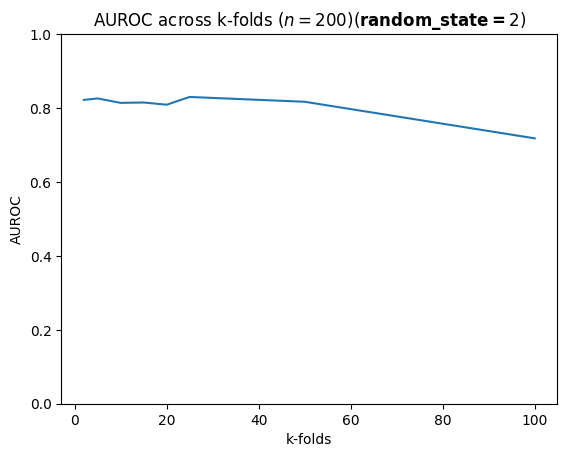

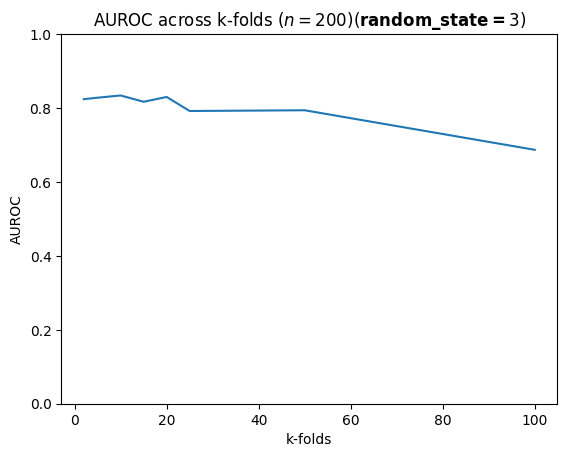

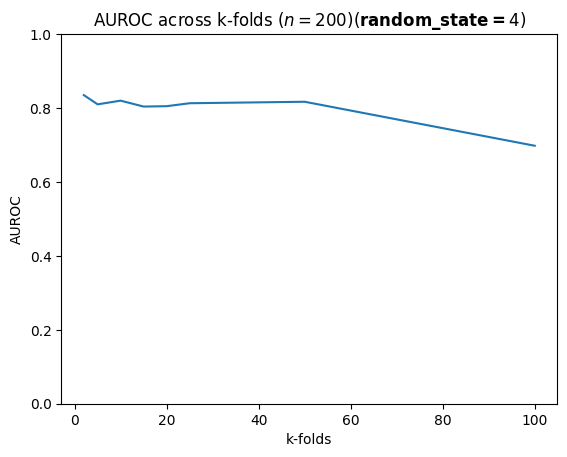

In [190]:
for d in list_200n_res:
    plot_performance(d, title_str= r'AUROC 200 samples ($\bf{random\_state}$=' )
for d in list_200n_res:
    k_v_auroc(d, title = "AUROC across k-folds ($n=200$)")

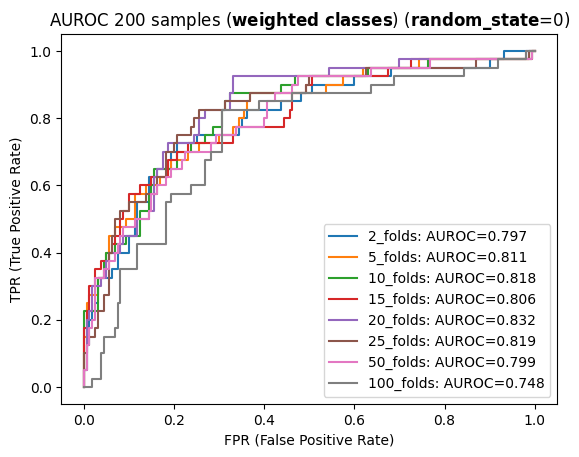

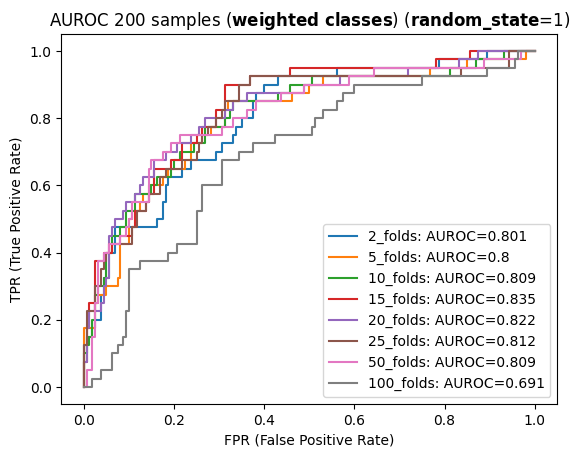

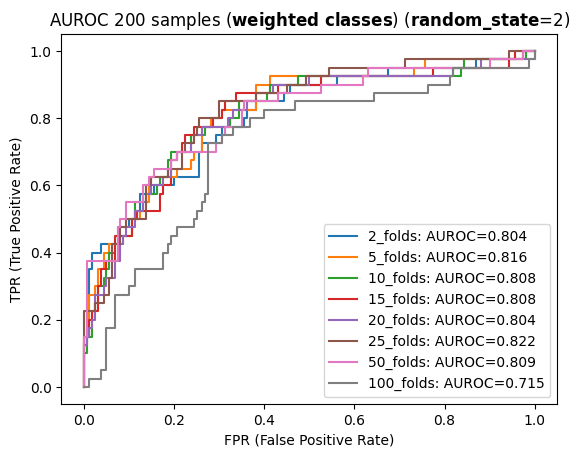

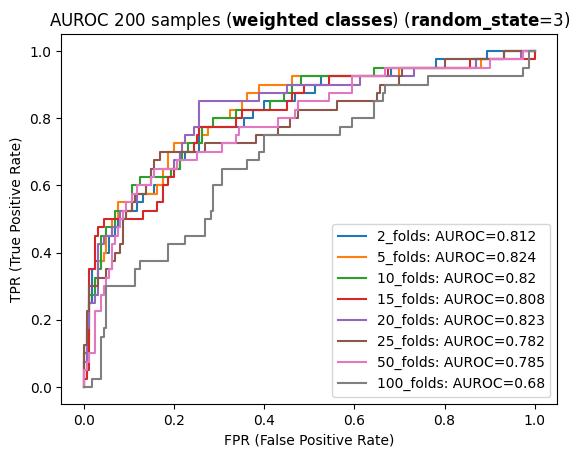

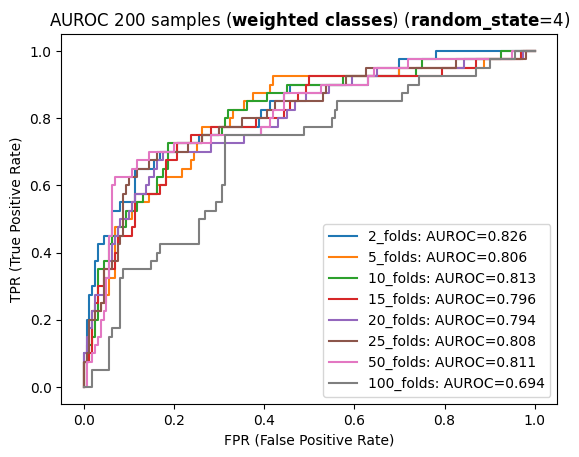

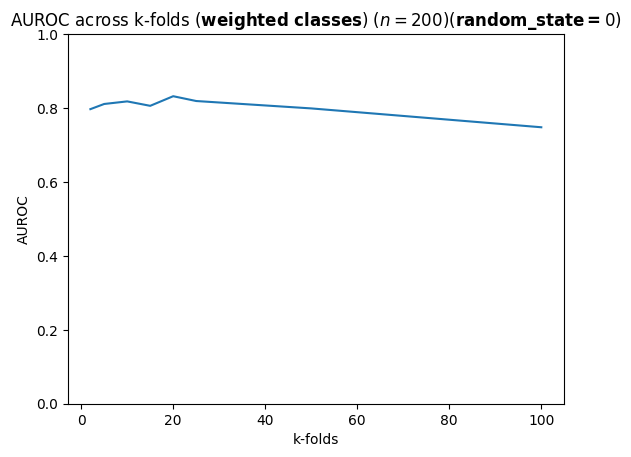

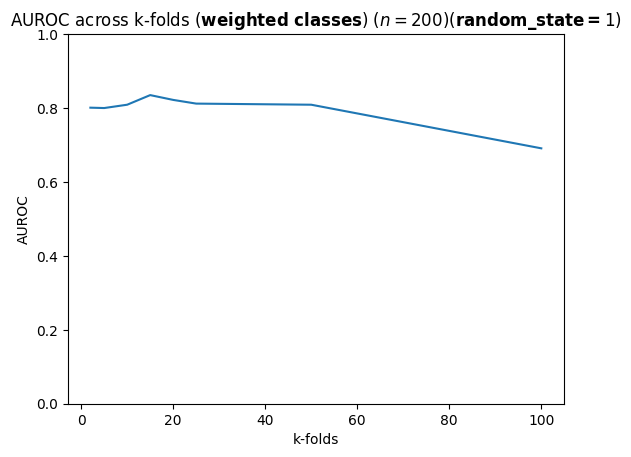

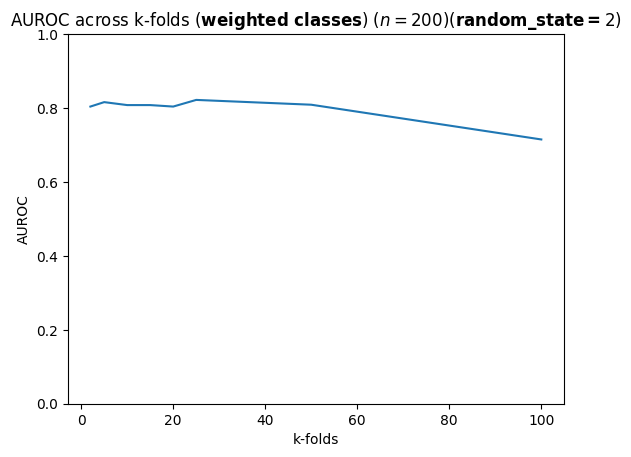

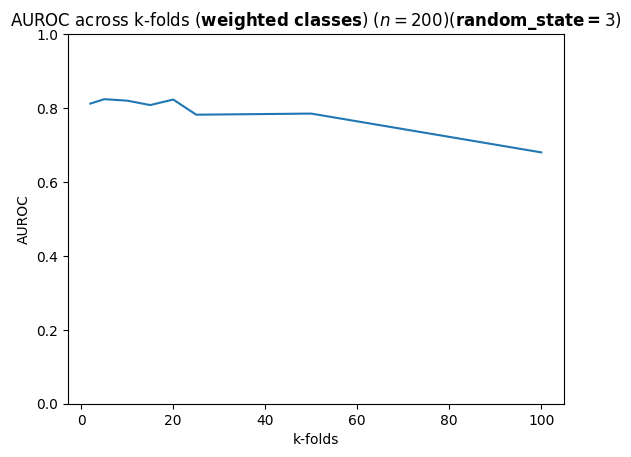

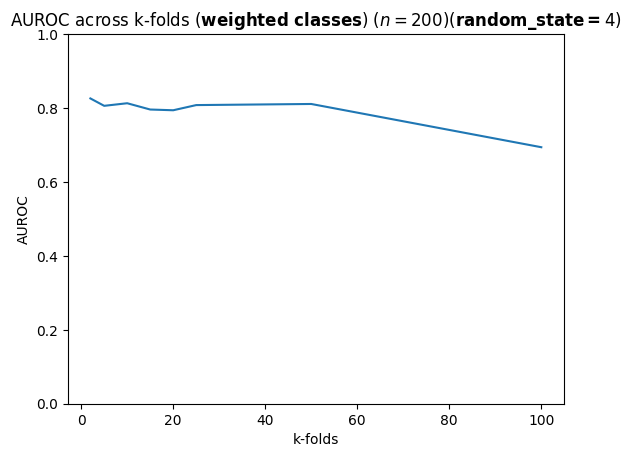

In [191]:
for d in list_200n_res_weighted:
    plot_performance(d, title_str= r'AUROC 200 samples ($\bf{weighted\ classes}$) ($\bf{random\_state}$=' )
for d in list_200n_res_weighted:
    k_v_auroc(d, title = r"AUROC across k-folds ($\bf{weighted\ classes}$) ($n=200$)")

In [192]:
sns.heatmap?

Signature:
sns.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise

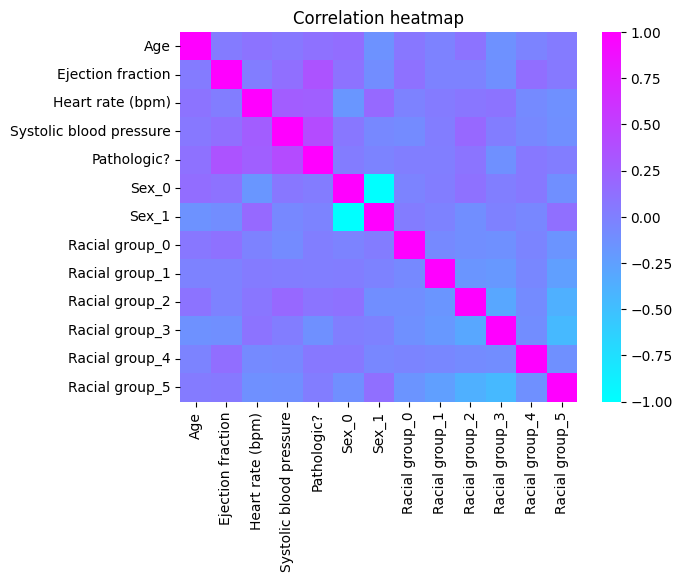

In [193]:
def df_correlation_heatmap(df):
    corr = df.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                cmap = 'cool')
    plt.title("Correlation heatmap")
df_correlation_heatmap(df_200_encoded)

In [194]:
#def partial_regression(df):
#
#x_i = x.loc[:, "Initial systolic pressure (mm Hg)"]
#    ax[1,0].scatter(x_i, y)
#    m, b = np.polyfit(x_i, y, 1)
#    x_i_sm = sm.add_constant(x_i)
#    model = sm.OLS(y, x_i_sm)
#    r_squared = round(model.fit().rsquared, 4)
#    ax[1,0].plot(x_i, (m*x_i)+b, color = "r")
#    ax[1,0].set_title(label = f"Initial systolic pressure (mm Hg) $R^{2} = ${r_squared}")
#    ax[1,0].title.set_size(8)
#    ax[1,0].set_ylabel('Systolic pressure after treatment (mm Hg)', size = 6)

In [201]:
?plt.hlines

Signature:
plt.hlines(
    y,
    xmin,
    xmax,
    colors=None,
    linestyles='solid',
    label='',
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot horizontal lines at each *y* from *xmin* to *xmax*.

Parameters
----------
y : float or array-like
    y-indexes where to plot the lines.

xmin, xmax : float or array-like
    Respective beginning and end of each line. If scalars are
    provided, all lines will have the same length.

colors : list of colors, default: :rc:`lines.color`

linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}, optional

label : str, default: ''

Returns
-------
`~matplotlib.collections.LineCollection`

Other Parameters
----------------
data : indexable object, optional
    If given, the following parameters also accept a string ``s``, which is
    interpreted as ``data[s]`` (unless this raises an exception):

    *y*, *xmin*, *xmax*, *colors*
**kwargs :  `~matplotlib.collections.LineCollection` properties.

See Also
--------
vlines : vertical lines


{'truth': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
 

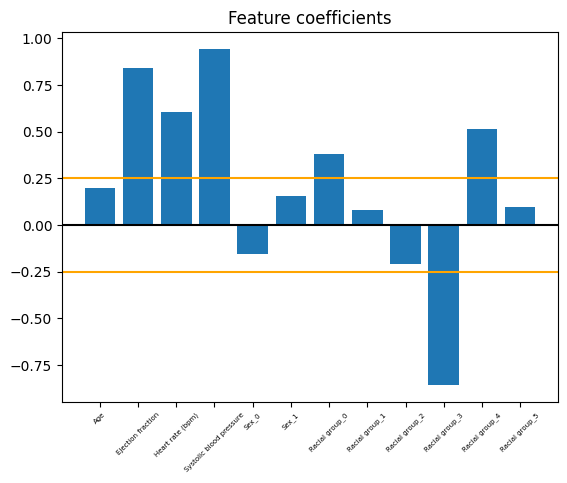

In [205]:
def test_model_on_train(df, class_weight = "balanced"):
    performance_dict =  {"truth": [], "p_0": [], "p_1": [], "f1": [], "acc": []}
    # Create a boolean mask using str.contains to match column names
    exclude_mask = df.columns.str.contains("Pathologic?")

# Use the boolean mask to select all columns except the one to exclude
    y = df.loc[:, "Pathologic?"]
    X = df.loc[:, ~exclude_mask]
    numerical_cols = ["Age", "Ejection fraction", "Heart rate (bpm)", "Systolic blood pressure"]
    X = standardize_df(X, *numerical_cols)

    clf = LogisticRegression(random_state=0, class_weight=class_weight)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    y_pred_prob = clf.predict_proba(X)
    pred_neg = y_pred_prob[:, 0].tolist()
    pred_pos = y_pred_prob[:, 1].tolist()
    acc = clf.score(X, y.tolist())
    f1 = f1_score(y.tolist(), y_pred, pos_label=1, zero_division=np.nan)
    performance_dict["truth"] += y.tolist()
    performance_dict["p_0"] += pred_neg
    performance_dict["p_1"] += pred_pos
    performance_dict["f1"] += [f1]
    performance_dict["acc"] += [acc]
    performance_dict["auroc"] = round(roc_auc_score(performance_dict["truth"], performance_dict["p_1"]), 3)
    plt.title('Feature coefficients')
    plt.hlines([-0.25, 0, 0.25], xmin = -1, xmax = 15, colors = ['orange', 'black', 'orange'])
    plt.bar(clf.feature_names_in_.tolist(), clf.coef_.tolist()[0])
    plt.xticks(fontsize=5, rotation=45)
    return(performance_dict)
dict_final = test_model_on_train(df_200_encoded)
dict_final

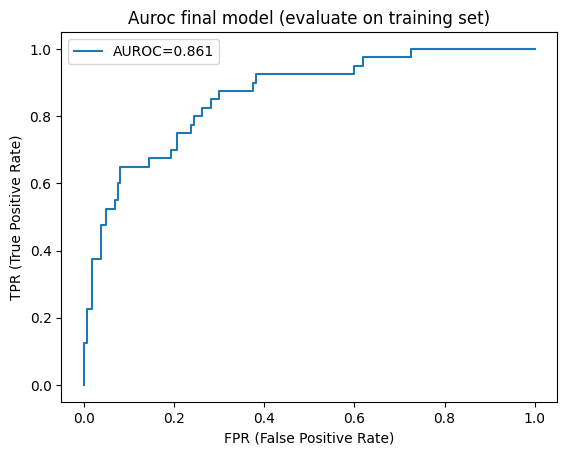

<module 'matplotlib.pyplot' from '/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [198]:

def plot_final_performance(performance_dict, title_str = r'Auroc final model (evaluate on training set)'):
    truth = performance_dict["truth"]
    p_1 = performance_dict["p_1"]
    f1 = performance_dict["f1"]
    acc = performance_dict["acc"]
    fpr, tpr, thres = sklearn.metrics.roc_curve(truth, p_1, pos_label=1)
    performance_dict["auroc"] = round(roc_auc_score(performance_dict["truth"], performance_dict["p_1"]), 3)
    auroc = performance_dict["auroc"]
    plt.plot(fpr, tpr, label = f'AUROC={auroc}') 
    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("TPR (True Positive Rate)")
    plt.title(title_str)
    plt.legend()
    plt.show()
    return(plt)

plot_final_performance(dict_final)